[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-06-14,37.000000,39.259998,37.000000,38.849998,27.591116,662600
2007-06-15,39.099998,39.099998,38.250000,38.799999,27.555603,1150000
2007-06-18,39.049999,39.099998,37.150002,37.150002,26.383789,853600
2007-06-19,37.150002,37.700001,36.099998,36.700001,26.064203,951000
2007-06-20,36.830002,36.830002,35.330002,35.950001,25.531544,1721800
...,...,...,...,...,...,...
2022-12-23,114.220001,114.580002,112.949997,113.949997,111.441551,1360300
2022-12-27,114.519997,114.519997,113.220001,113.860001,111.353546,972600
2022-12-28,113.900002,114.470001,111.940002,112.230003,109.759430,1452700


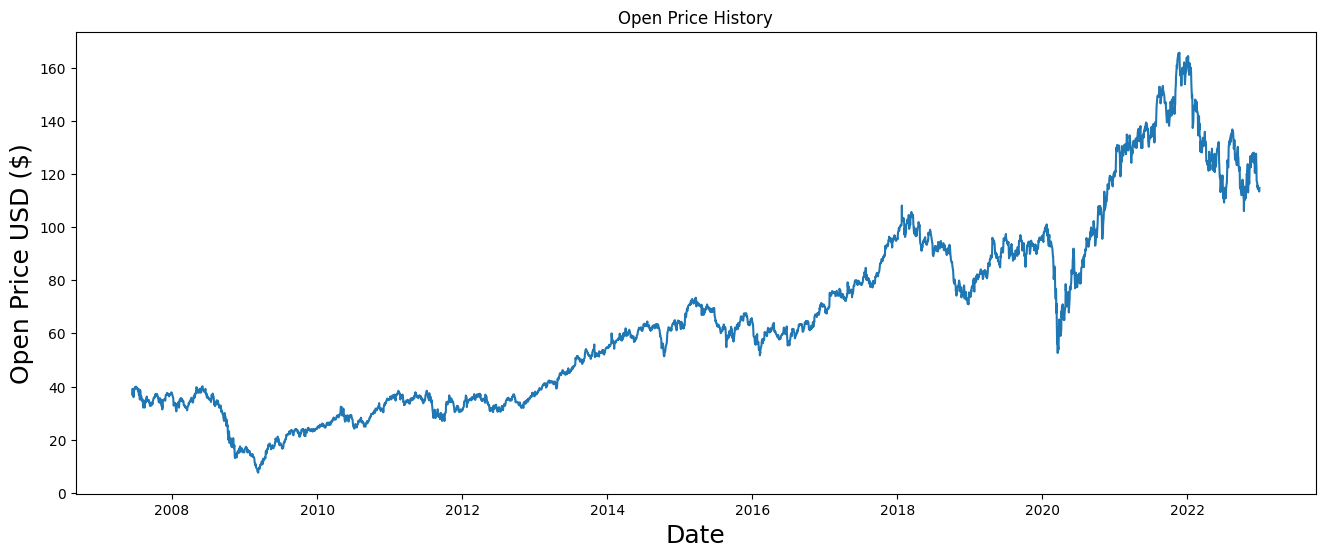

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0593
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6.235331054808274


/tmp/ipykernel_33/3852738088.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


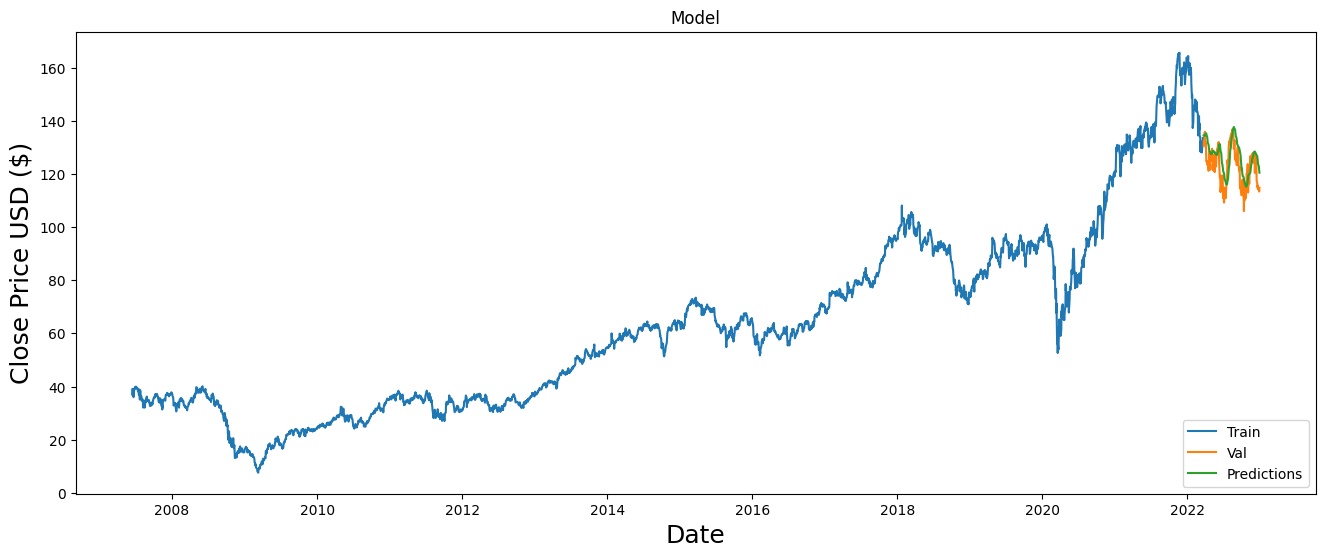

<Axes: xlabel='Date'>

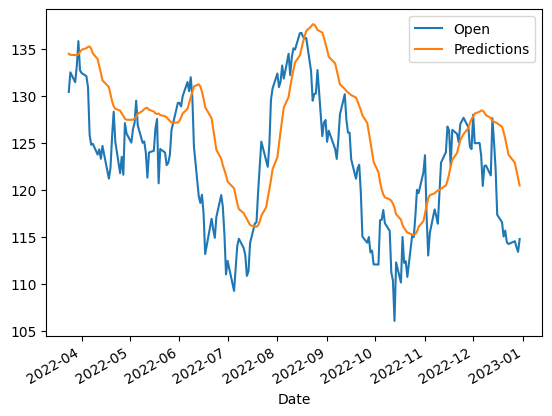

In [67]:


from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Specify the date range

start_date = '1993-04-05'  # Example start date
end_date = '2023-01-01'    # Example end date

# Fetch stock data for BMW within the specified time period
df= get_stock_data('TEL', start_date, end_date)
#VOLV-B.ST
#VOLV-B.ST
# Display the stock data
display(df)
plt.figure(figsize=(16,6))
plt.title('Open Price History')
plt.plot(df['Open'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.show()

# Create a new dataframe with only the 'Close column 
data = df.filter(['Open'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
#    if i<= 61:
#        print(x_train)
#        print(y_train)
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=1)
#0.0077 
#0.0064 when  2011-01-01

# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(rmse)
#4.95
#2.95
#4/42

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

valid.plot()

1. ADF :  -0.7125043715294368
2. P-Value :  0.8434839827228853
3. Num Of Lags :  27
4. Num Of Observations Used For ADF Regression: 3888
5. Critical Values :
	 1% :  -3.4320330305147984
	 5% :  -2.8622836706894352
	 10% :  -2.5671658648352427
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12993.260, Time=6.98 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13005.581, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13007.050, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13007.052, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13004.490, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13011.028, Time=0.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13011.035, Time=0.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=12994.426, Time=2.81 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=13011.176, Time=7.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13008.911, Time=0.81 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=12

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


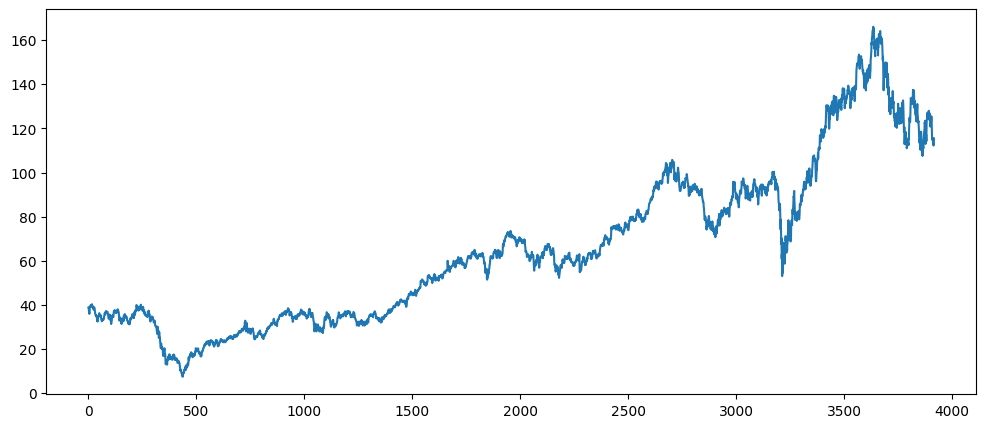

In [81]:
#!pip install pmdarima

df['Close'].plot(figsize=(12,5))
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(df['Close'])

from pmdarima import auto_arima
stepwise_fit = auto_arima(df['Close'], trace=True,
suppress_warnings=True)

print(df.shape)
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape,test.shape)

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(train['Close'],order=(1,0,5))

model=model.fit()
model.summary()


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: >

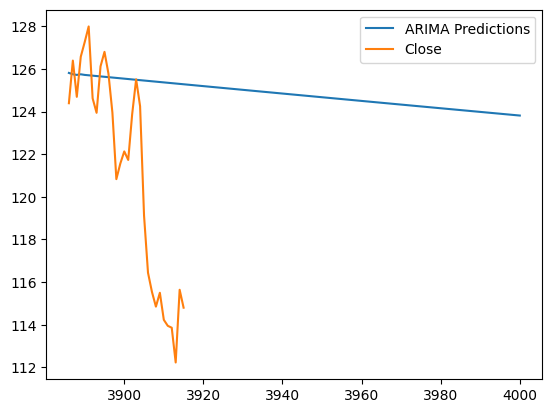

In [85]:
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(train['Close'],order=(1,0,5))

model=model.fit()
model.summary()

start=len(train)
end=4000
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['Close'].plot(legend=True)



[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index 

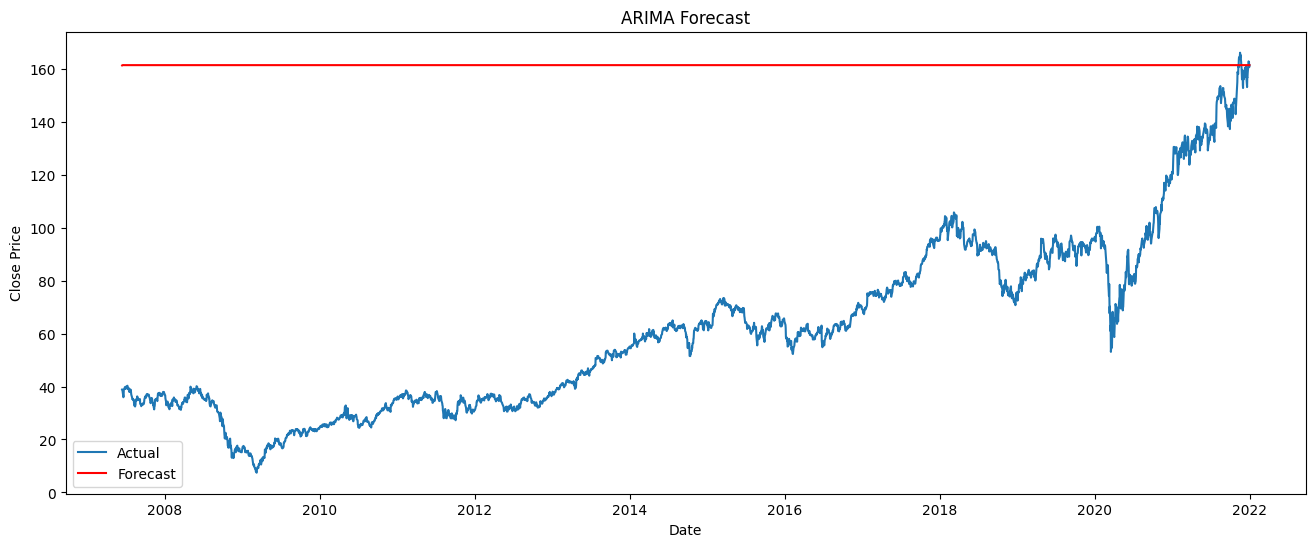

In [45]:
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Specify the date range
start_date = '1993-04-05'  # Example start date
end_date = '2022-01-01'    # Example end date

# Fetch stock data for TEL within the specified time period
df = get_stock_data('TEL', start_date, end_date)

# Create a new dataframe with only the 'Close' column 
data = df['Close']

# Fit ARIMA model
model = ARIMA(data, order=(5,1,0)) # Example ARIMA order (p,d,q)
results = model.fit()

# Generate predictions
forecast = results.forecast(steps=len(data))

plt.figure(figsize=(16,6))
plt.plot(data, label='Actual')
plt.plot(data.index, forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [46]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import yfinance as yf
import numpy as np
import pandas as pd
import yfinance as yf
import pandas as pd
import yfinance as yf
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

^C
ERROR: Operation cancelled by user


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index 

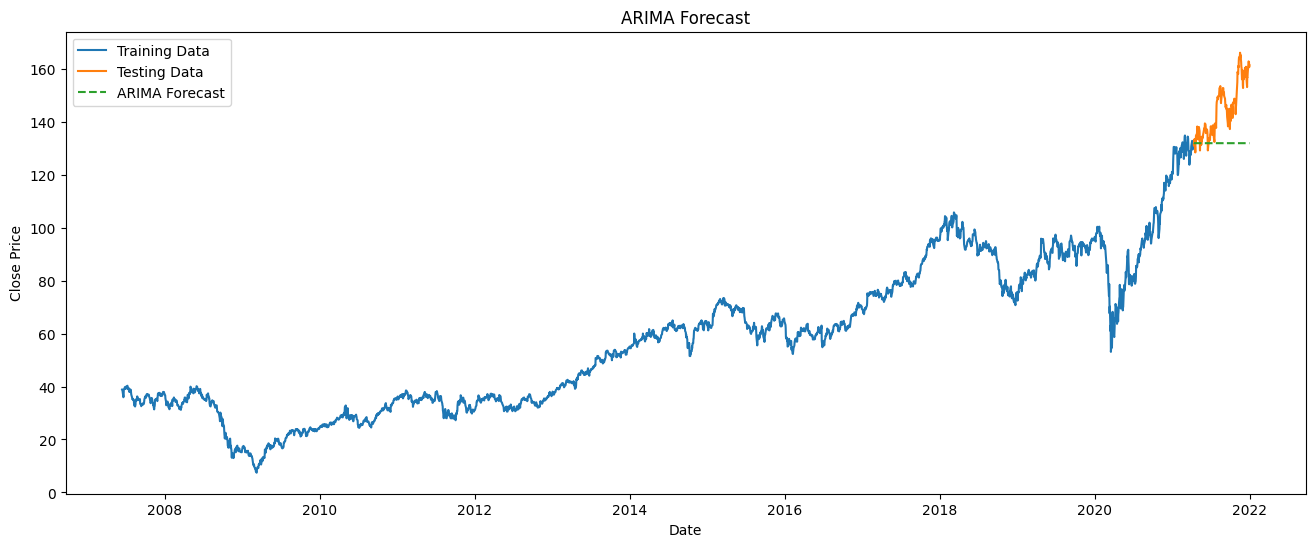

RMSE: 16.351470876761688


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler

# Load your data
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Specify the date range
start_date = '1993-04-05'  # Example start date
end_date = '2022-01-01'    # Example end date

# Fetch stock data for TEL within the specified time period
df = get_stock_data('TEL', start_date, end_date)

# Select the 'Close' column for ARIMA forecasting
data = df['Close']

# Split data into training and testing sets
train_data = data[:int(0.95*len(data))]
test_data = data[int(0.95*len(data)):]

# Fit ARIMA model
model = ARIMA(train_data, order=(5,1,0)) # Example order (p,d,q)
arima_model = model.fit()

# Forecast future values
forecast = arima_model.forecast(steps=len(test_data))

# Plot results
plt.figure(figsize=(16,6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Testing Data')
plt.plot(test_data.index, forecast, label='ARIMA Forecast', linestyle='--')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print("RMSE:", rmse)